In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import os
from glob import glob
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from scipy.spatial.distance import correlation
from IPython.display import display

In [3]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, 
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_morlet, tfr_multitaper, psd_multitaper, psd_welch, psd_array_multitaper, 
                                csd_array_fourier, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
0.23.4


In [4]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [5]:
# Configure the graphics engine

import matplotlib.pyplot as plt
plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [6]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [7]:
print(os.getcwd())

if not os.path.exists('work_data'):
    os.mkdir('work_data')

C:\Users\Lenovo\PycharmProjects\Tibet


# Loading data

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<IPython.core.display.Javascript object>


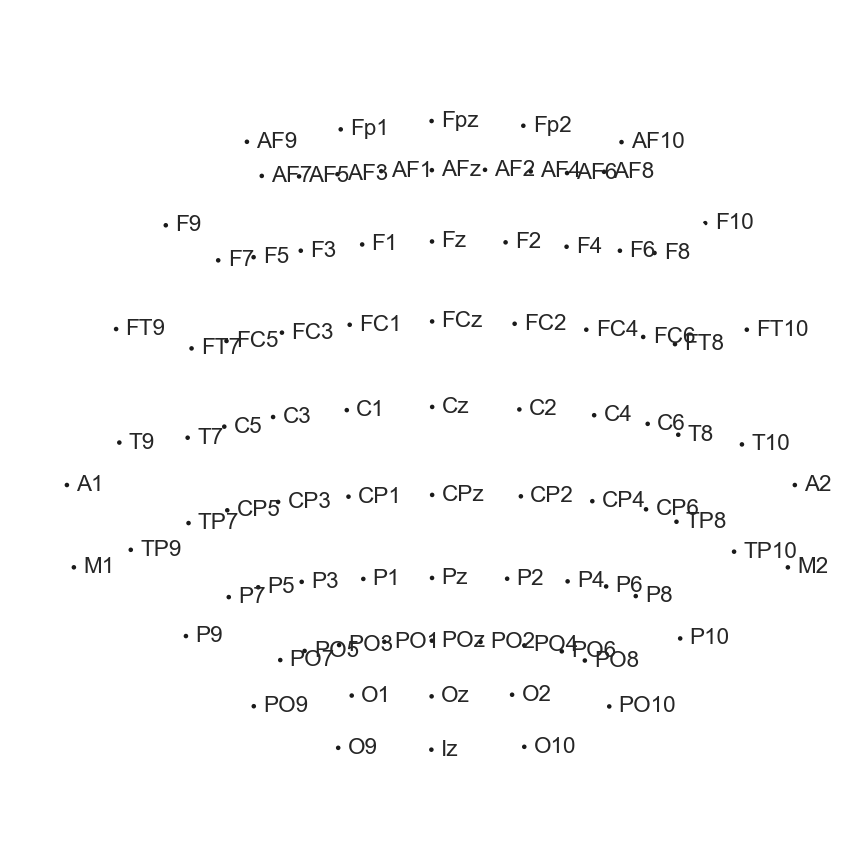

In [8]:
montage = mne.channels.make_standard_montage('standard_1020')

fig = montage.plot(kind='topomap', show_names=True)

Extracting EDF parameters from C:\Users\Lenovo\PycharmProjects\Tibet\work_data\m10_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 491999  =      0.000 ...   983.998 secs...
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft7', 'Fc3', 'Fcz', 'Fc4', 'Ft8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp7', 'Cp3', 'Cpz', 'Cp4', 'Tp8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'Po3', 'Poz', 'Po4', 'P6', 'Po7', 'O1', 'Oz', 'O2', 'Po8', 'ecg', 'Sound', 'Accelerometer', 'resp']
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Ft7, Fc3, Fcz, Fc4, Ft8, T3, ...
 chs: 44 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 70.0 Hz
 meas_date: 2020-03-01 06:31:33 UTC
 nchan: 44
 projs: []
 sfreq: 500.0 Hz
>


<IPython.core.display.Javascript object>


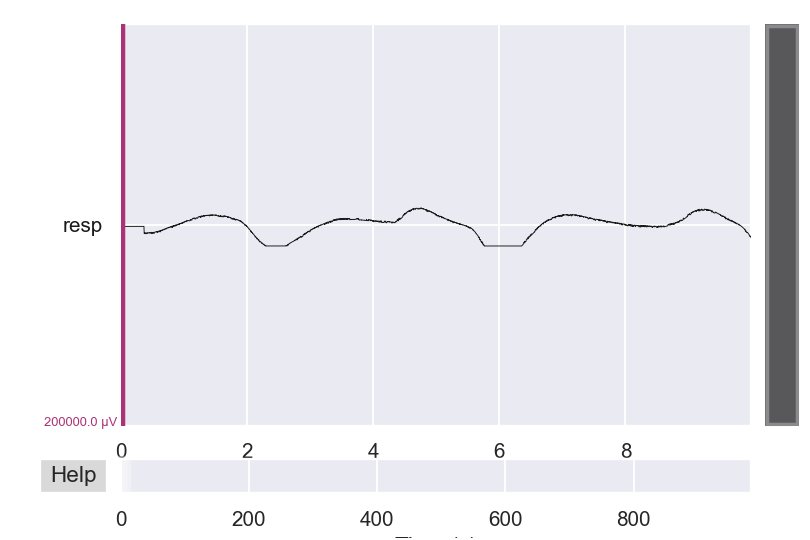

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


<IPython.core.display.Javascript object>


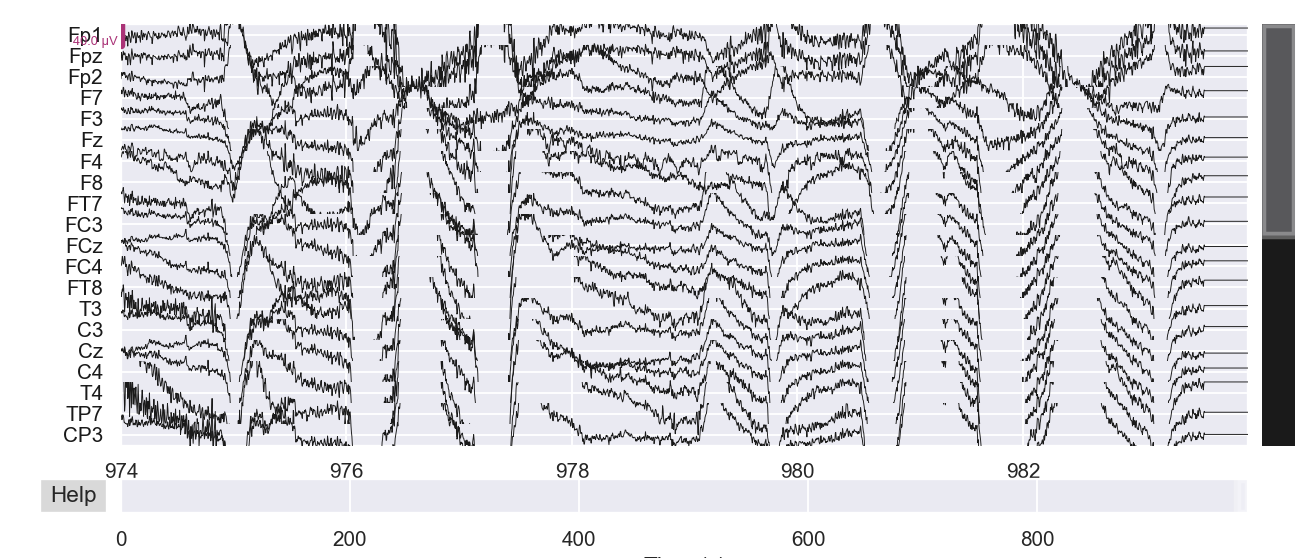

<RawEDF | m10_40.edf, 40 x 492000 (984.0 s), ~150.2 MB, data loaded>

In [78]:
#Fp_chan=['Fpz', 'Fp1', 'Fp2','Fz']
#C_chan=['Cz', 'C3','C4','C1', 'C2']
#P_chan=['Pz', 'P3', 'P4', 'P8', 'P7', 'P6', 'P5', 'P1', 'P2']
#PO_chan=['POz', 'PO3', 'PO7','PO4', 'PO8'] 
#O_chan= ['Oz', 'O1', 'O2']
#Cz_chan=['CPz','FCz']

ECG_ch = ['ecg']
resp_ch = ['resp']
sound_ch = ['Sound']
accel_ch = ['Accelerometer']

data_raw = mne.io.read_raw_edf(os.path.join('work_data', r"m10_40.edf"), preload=True)
#annot = mne.read_annotations(os.path.join('work_data', r'm10-annot.csv'))
#data.set_annotations(annot)
sampling_rate = data_raw.info['sfreq']

print(data_raw.info.ch_names)
print(data_raw.info)


#data_eog = data.copy().pick_channels(EOG_ch)
data_ecg = data_raw.copy().pick_channels(ECG_ch)
#data_ecg.plot(scalings = dict(eeg=100e-4), duration=10)
data_resp = data_raw.copy().pick_channels(resp_ch)
data_resp.plot(scalings = dict(eeg=100e-3), duration=10)

data_raw.drop_channels(['ecg', 'resp', 'Sound', 'Accelerometer'])
#data_raw.rename_channels(lambda s: s[:-1].upper()+s[-1])
data_raw.rename_channels({'Ft7':'FT7', 'Fc3':'FC3', 'Fcz':'FCz', 'Fc4':'FC4', 'Ft8':'FT8', 'Tp7':'TP7', 'Cp3':'CP3', 
                          'Cpz':'CPz', 'Cp4':'CP4', 'Tp8':'TP8', 'Po3':'PO3', 'Poz':'POz', 'Po4':'PO4', 'Po7':'PO7', 
                          'Po8':'PO8'})
data_raw.set_montage('standard_1020')
#data.set_channel_types(change_types)
print(data_raw.ch_names)
data_raw.plot(duration=10)
print()
data_raw

<IPython.core.display.Javascript object>


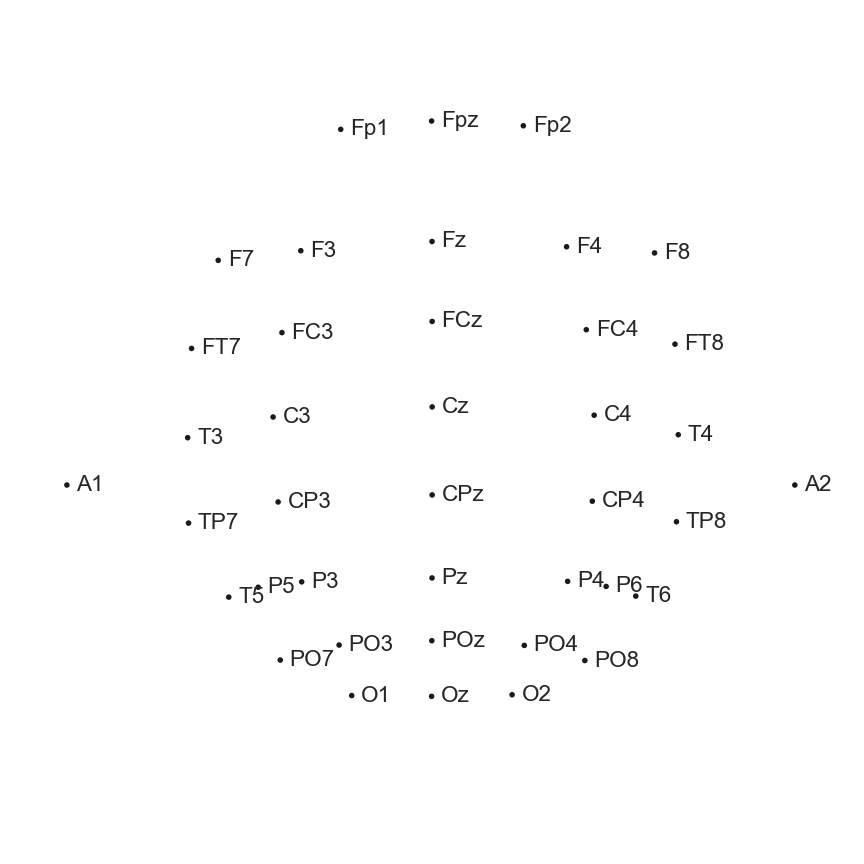

In [9]:
data_raw.plot_sensors(ch_type='eeg', show_names=True)
print()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



<IPython.core.display.Javascript object>


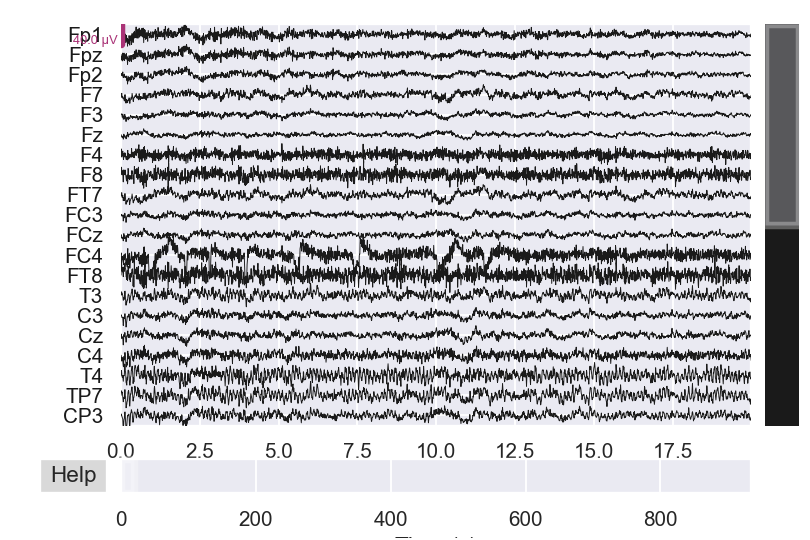

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



<IPython.core.display.Javascript object>


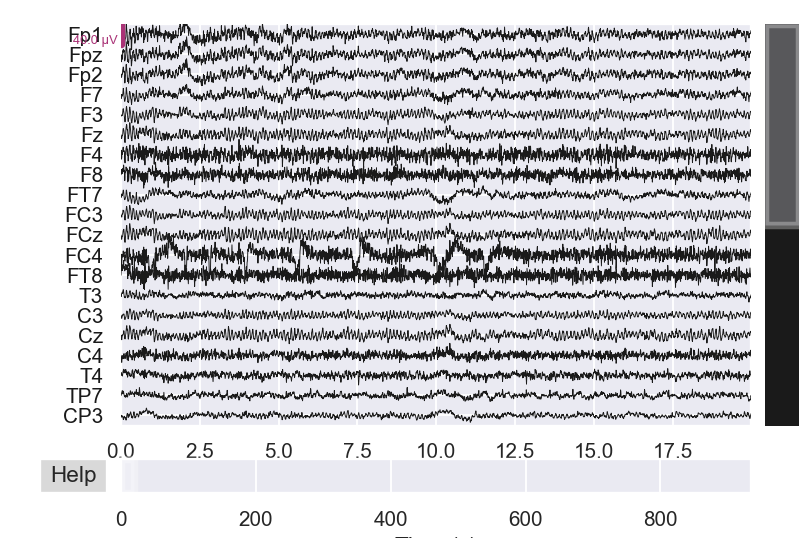

In [9]:
# Re-referencing raw data (common average reference)
bands = [(0.9, 4, 'Delta (0.9-4 Hz)'), (4, 8, 'Theta (4-8 Hz)'), (8, 14, 'Alpha (8-14 Hz)'), 
         (14, 25, 'Beta (14-25 Hz)'), (25, 40, 'Gamma (25-40 Hz)')]

data_raw_filt = data_raw.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
fig_orig = data_raw_filt.plot(duration=20)

rr_data_raw, ref_ch = mne.set_eeg_reference(data_raw, ref_channels='average', copy=True, projection=False, ch_type='auto')
rr_data_raw_filt = rr_data_raw.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
fig_reref = rr_data_raw_filt.plot(duration=20)


<IPython.core.display.Javascript object>


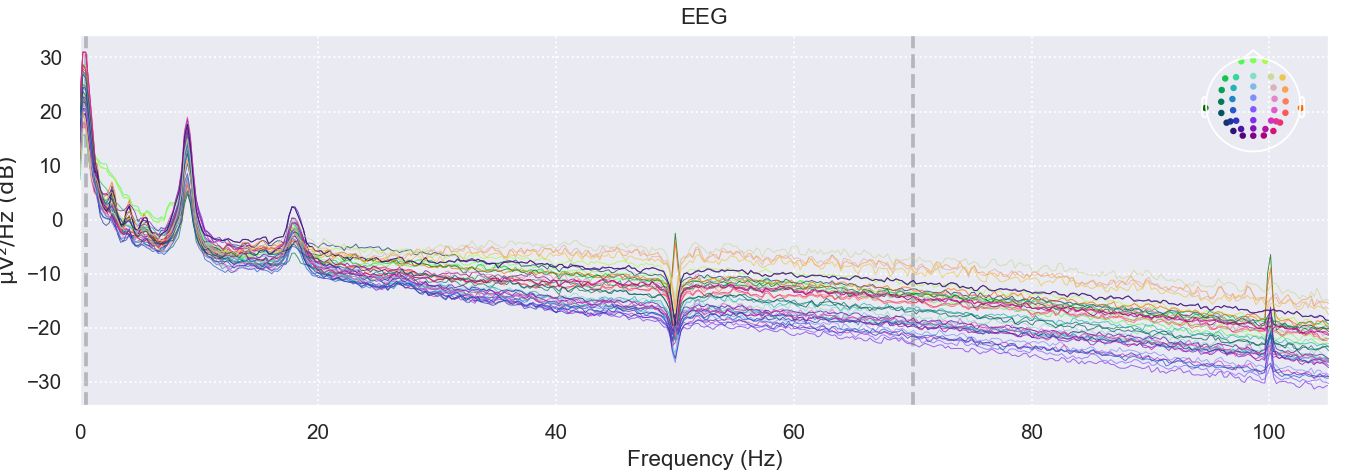

Effective window size : 4.096 (s)



In [13]:
rr_data_raw.plot_psd(fmin=0, fmax=105)
print()

<IPython.core.display.Javascript object>


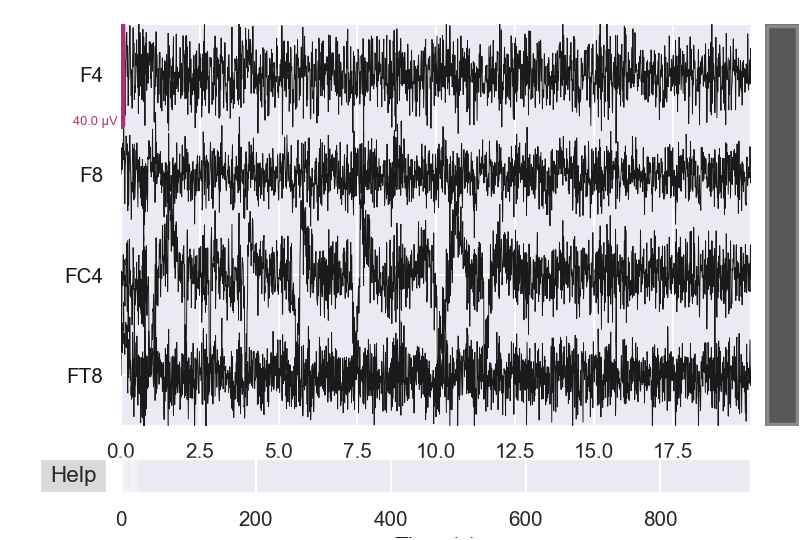

In [14]:
rr_data_pick = rr_data_raw_filt.copy().pick_channels(['Fpz', 'Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz', 'Oz'])
rr_data_pick = rr_data_raw_filt.copy().pick_channels(['C3', 'Cz', 'CP3', 'CPz', 'P3', 'P5', 'Pz'])#, 'PO4', 'PO8', 'O2', 'Oz', 'POz'])
rr_data_pick = rr_data_raw_filt.copy().pick_channels(['F4', 'F8', 'FC4', 'FT8'])

rr_data_pick.plot(duration=20)
print()

# Preprocessing data

## ICA preparation 

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 825 samples (1.650 sec)

Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by explained variance: 27 components
Fitting ICA took 19.2s.
Creating RawArray with float64 data, n_channels=27, n_times=467501
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.


<IPython.core.display.Javascript object>


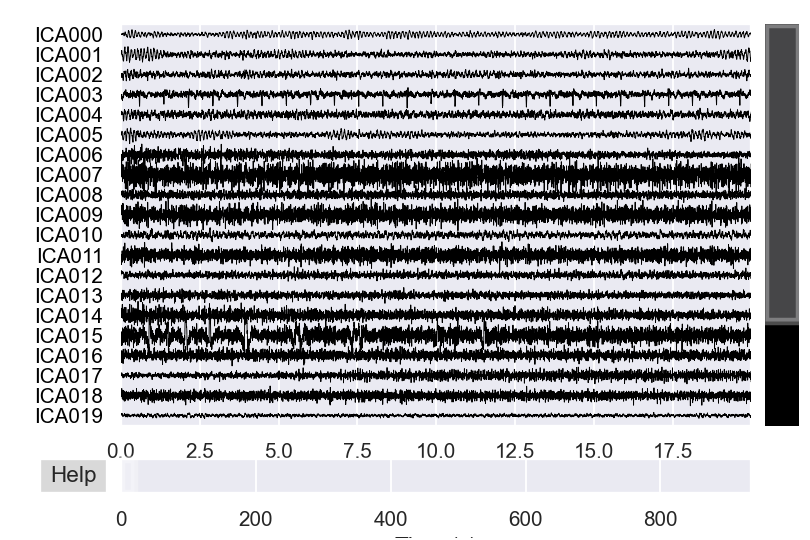

<IPython.core.display.Javascript object>


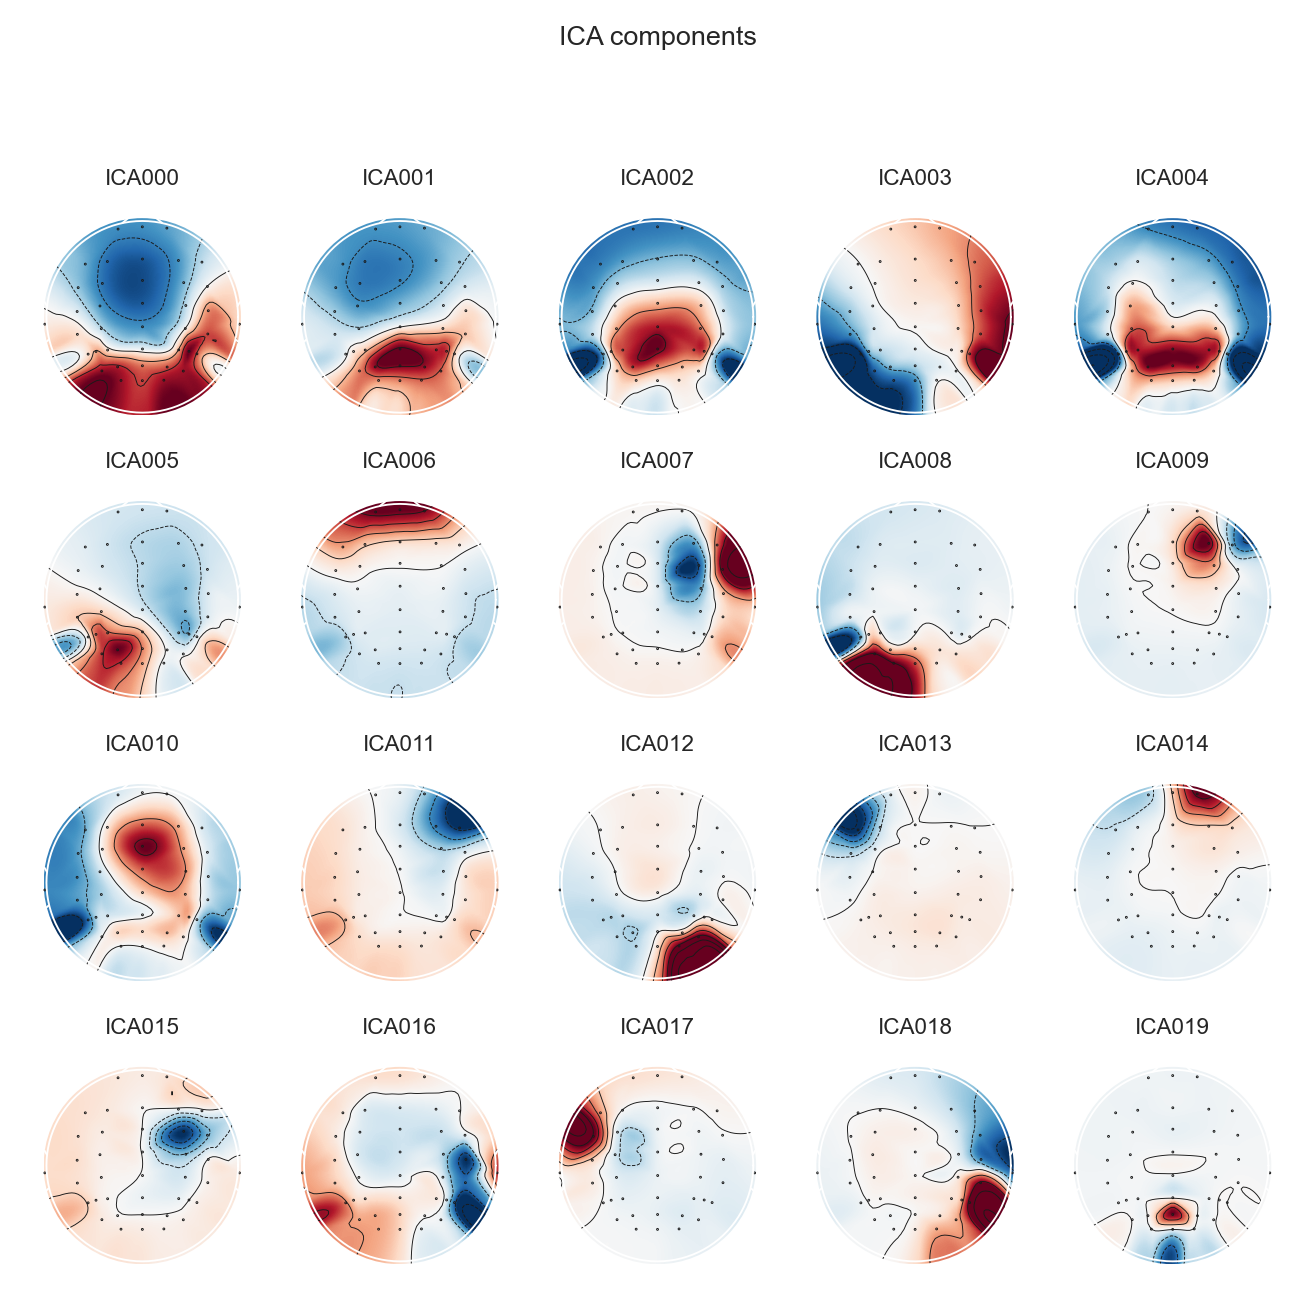

<IPython.core.display.Javascript object>


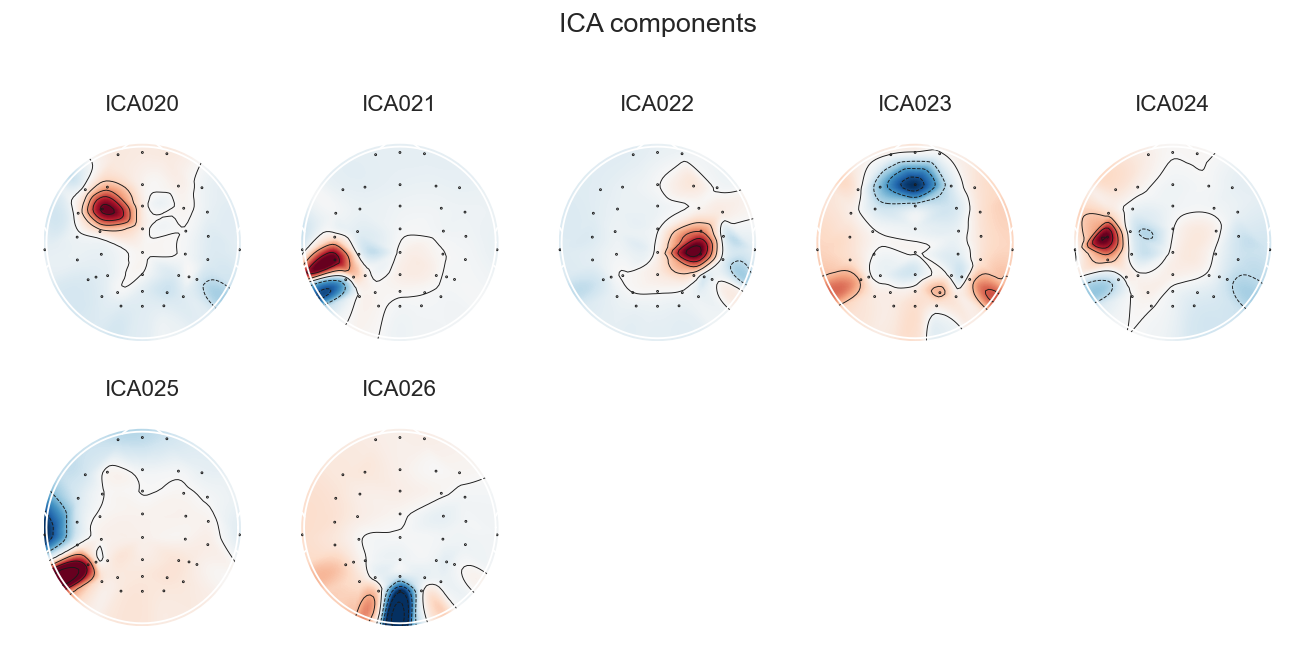

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 7 Axes>]

In [13]:
rr_data_ica = rr_data_raw.copy()
#rr_data_ica.info['bads']=["F4","F8"]
#rr_data_ica.interpolate_bads(reset_bads=True)

rr_data_ica.filter(l_freq=4., h_freq=None)

rr_ica = ICA(n_components=.99, max_iter='auto', random_state=97)
rr_ica.fit(rr_data_ica)

rr_ica.plot_sources(rr_data_ica)
rr_ica.plot_components()

Using ICA source to identify heart beats
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 5000 samples (10.000 sec)

[111. 111. 111. ... 111. 111. 111.]
[  3794.   4180.   4571. ... 471229. 471594. 471976.]
Not setting metadata
Not setting metadata
1277 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1277 events and 351 original time points ...
1 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


<IPython.core.display.Javascript object>


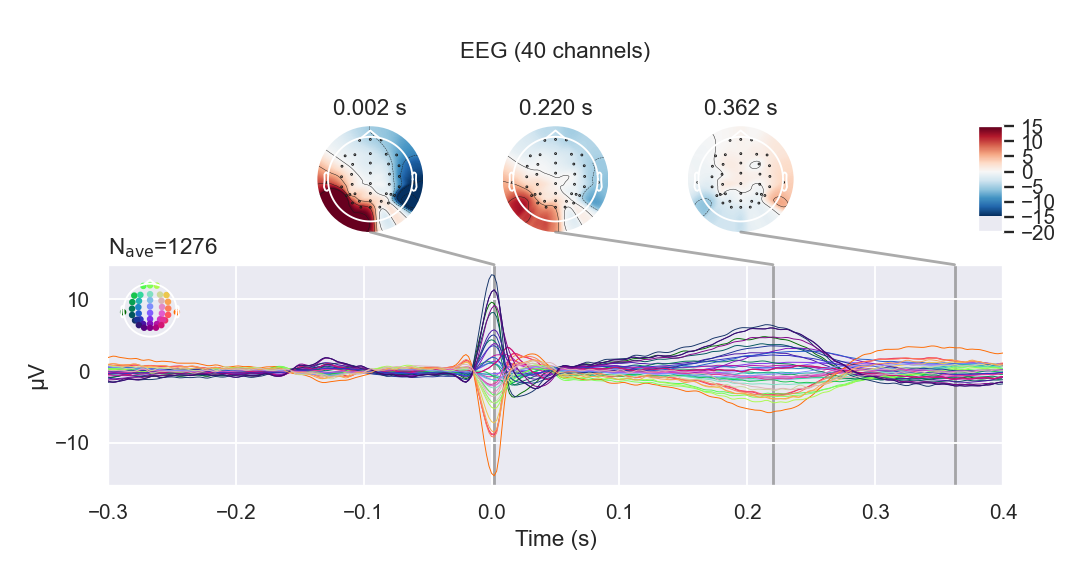

In [71]:
# Extract the time courses of these components and add them as channels to the raw data. 
# Think of them the same way as EOG/EKG channels
rr_ecg_comps = rr_ica.get_sources(rr_data_ica).get_data()
#ecg_comps.pick(picks='ICA003')
#(ecg_comps.info)

rr_ecg_events = ica_find_ecg_events(rr_data_ica, 
                             rr_ecg_comps[3], 
                             event_id=111, 
                             l_freq=5, h_freq=35, 
                             )
print(rr_ecg_events[:,2])
print(np.unique(rr_ecg_events[:,0]))


rr_evoked_ECG = mne.Epochs(rr_data_raw, rr_ecg_events.astype(int),
                            #detrend=1,
                            decim=1,
                            #baseline=(-0.15,0.0),
                            tmin=-0.3, tmax=0.4, 
                            preload=True).average()
rr_evoked_ECG.plot_joint()
print()

#data_ica.add_channels([ecg_comps])

#ecg_comps.rename_channels({'ICA003': 'ecg_ICA003'})
#ecg_comps.set_channel_types({'ICA003': 'ecg'})


Applying ICA to Evoked instance
    Transforming to ICA space (27 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components


<ipython-input-73-944f4f25e7ca>:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  rr_ica.plot_overlay(rr_evoked_ECG, exclude=[3])


<IPython.core.display.Javascript object>


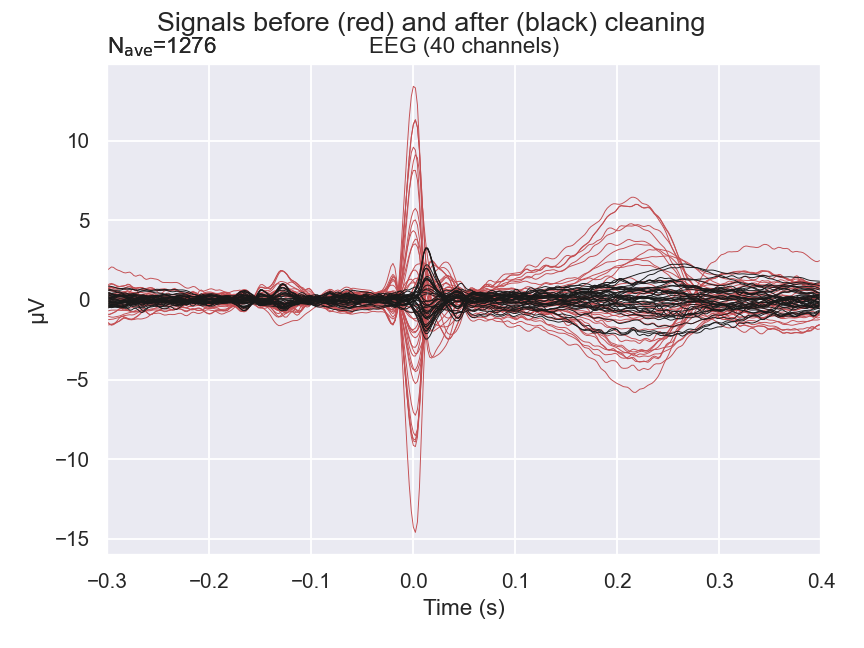

<IPython.core.display.Javascript object>


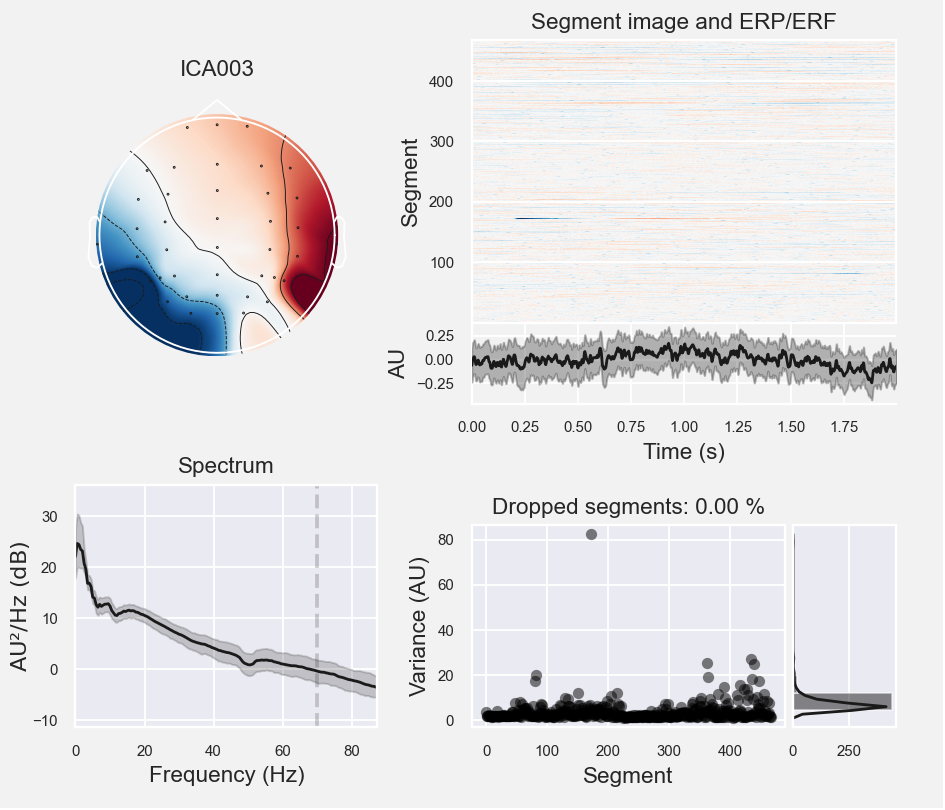

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
468 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>]

In [73]:
rr_ica.plot_overlay(rr_evoked_ECG, exclude=[3])
rr_ica.plot_properties(rr_data_raw, picks=[3])

Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components


<IPython.core.display.Javascript object>


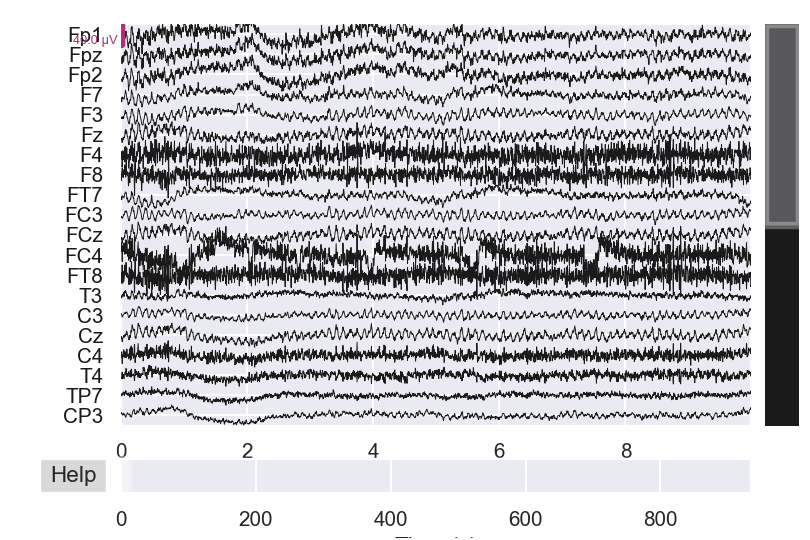

<IPython.core.display.Javascript object>


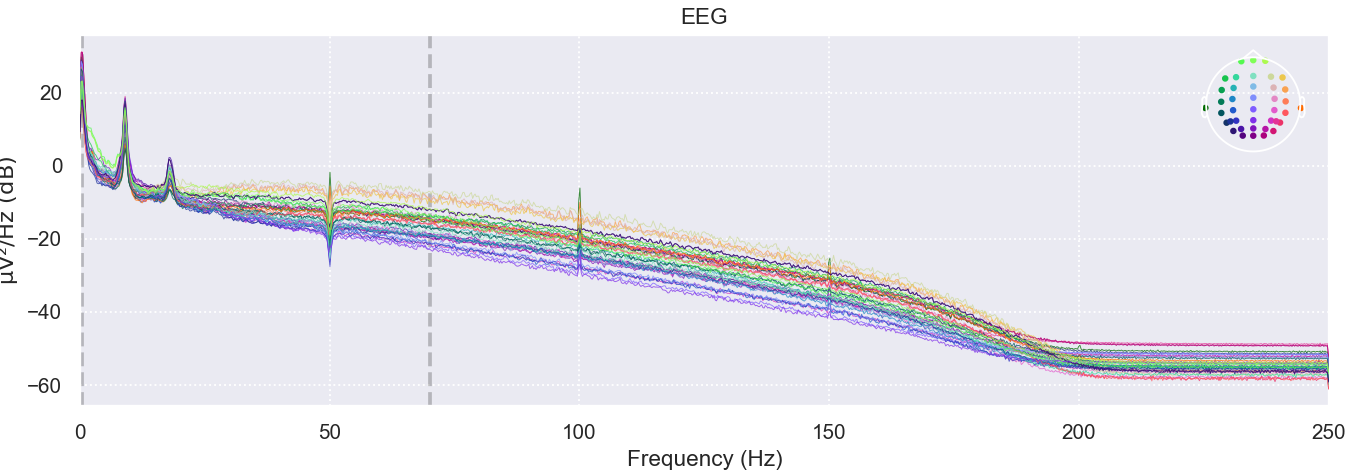

Effective window size : 4.096 (s)



In [14]:
# Exclude ECG channel (re-referenced data)
rr_ica.exclude = [3] 
reref_data = rr_data_raw.copy()
rr_ica.apply(reref_data)

reref_data.plot()
reref_data.plot_psd()

#rr_data_notch = reref_data.copy().notch_filter([50])
#rr_data_notch.plot_psd()#fmin=0, fmax=105)
print()

# Epoching data

In [15]:
# Filtering raw_data
bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq

# Re-referenced data
data_rr_filt = reref_data.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
data_rr_filt_spectr = []
for i in range(len(bands)):
    data_rr_filt_spectr.append(reref_data.copy().filter(l_freq=bands[i][0], h_freq=bands[i][1]))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband e

Not setting metadata
Not setting metadata
1167 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1167 events and 501 original time points ...
0 bad epochs dropped
(1167, 3)
<Epochs |  1163 events (all good), -0.5 - 0.5 sec, baseline off, ~177.9 MB, data loaded,
 '1': 1163>
(1163, 40, 501)
Not setting metadata
Not setting metadata
1167 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1167 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
1167 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1167 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
1167 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1167 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
Not 

<IPython.core.display.Javascript object>


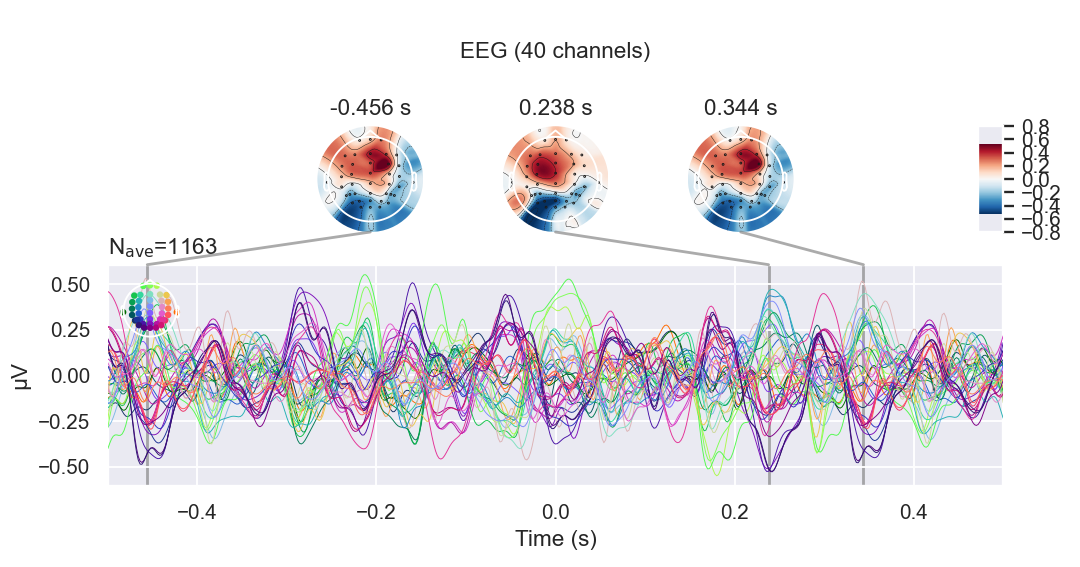

In [17]:
# Epochs by fixed length events, duration 1s, overlap 0.2s (re-referenced)

fix_1s_events_rr = mne.make_fixed_length_events(data_rr_filt, start=0.5, duration=1.)#, overlap=0.2)
kwargs = dict(baseline=None, tmin=-0.5, tmax=0.5, preload=True)

epochs_fix_1s_rr = mne.Epochs(data_rr_filt, fix_1s_events_rr.astype(int), **kwargs)
epochs_fix_1s_rr = epochs_fix_1s_rr[2:-2] #remove first and last 2sec due to possible filtering artefacts

print(fix_1s_events_rr.shape)
print(epochs_fix_1s_rr)
print(epochs_fix_1s_rr.get_data().shape)
#print(epochs_fix_1s_rr.events)

epochs_fix_rr_spectr = []
for i in range(len(bands)):   
    epochs_fix_rr_spectr.append(mne.Epochs(data_rr_filt_spectr[i], fix_1s_events_rr.astype(int), **kwargs))
    epochs_fix_rr_spectr[i] = epochs_fix_rr_spectr[i][2:-2] 

epochs_fix_1s_rr.average().plot_joint()
print()

# Extract features

In [18]:
# Global variables
regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central'), (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal'), 
           (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital')]


ch_names = data_raw.ch_names
n_freq = len(str_freq_rr)
n_channels = len(ch_names)
n_regions = len(regions)
n_regions_plt = len(regions_plt)

n_samples = epochs_fix_1s_rr.__len__()
n_times = len(epochs_fix_1s_rr.get_data()[0,0,:])

print(ch_names)

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


## TDA features

In [41]:
# Global variables

#tda_root_path = os.getcwd()+'\TDA_data\m10\\'  # R3
#excel_root_path = os.getcwd()+'\excel_data\m10\\'  # R3
tda_root_path = os.getcwd()+'\TDA_data\m10\R2\\'  # R2
excel_root_path = os.getcwd()+'\excel_data\m10\R2\\'  # R2
#print(tda_root_path)

#tda_bands = [(0.9, 4, 'D', 'Delta (0.9-4 Hz)', 15), (4, 8, 'T', 'Theta (4-8 Hz)', 12), (8, 14, 'A', 'Alpha (8-14 Hz)', 10), 
#             (14, 20, 'B1', 'Beta1 (14-20 Hz)', 8), (20, 25, 'B2', 'Beta2 (20-25 Hz)', 6), (25, 30, 'G1', 'Gamma1 (25-30 Hz)', 4), 
#             (30, 35, 'G2', 'Gamma2 (30-35 Hz)', 3), (35, 40, 'G3', 'Gamma3 (35-40 Hz)', 3)]

tda_bands = [(0.9, 4, 'D', 'Delta (0.9-4 Hz)', 15), (4, 8, 'T', 'Theta (4-8 Hz)', 12), (8, 14, 'A', 'Alpha (8-14 Hz)', 10), 
             (14, 25, 'B', 'Beta (14-25 Hz)', 7), (25, 40, 'G', 'Gamma (25-40 Hz)', 4)]

tda_metrics = [('bottleneck','botl'), ('wasserstein', 'wass'), ('betti', 'bet'), ('landscape', 'land')] 
#           ('silhouette', 'silh'), ('heat', 'heat'), ('persistence_image', 'img')]

#hom_dims = [1, 2] # Considered homology dimensions R3
hom_dims = [1] # Considered homology dimensions R2

#l_norms = [1, 2] # Norm orders for produsing features

persistence = VietorisRipsPersistence(
    homology_dimensions=hom_dims, 
    n_jobs=-1,
)

In [42]:
# Load persistent diagrams (re-referenced data)

# Full range
dir_name = 'pd_ft_rr_tda'
target_dir = tda_root_path + dir_name

pd_ft_rr_tda_raw = []
print('Full range')
for i in range(n_channels):
    pd_ft_rr_tda_raw.append(np.load(os.path.join(target_dir, dir_name+'_'+str(i)+'.npy')))
    print(i, pd_ft_rr_tda_raw[i].shape)
    
# By spectrum
pd_ft_rr_tda_sp_raw = []
for _freq in range(len(tda_bands)):
    dir_name = 'pd_ft_rr_tda_'+tda_bands[_freq][2]
    target_dir = tda_root_path + dir_name

    pd_ft_rr_tda_band = []
    print(tda_bands[_freq][3])
    for i in range(n_channels):
        pd_ft_rr_tda_band.append(np.load(os.path.join(target_dir, dir_name+'_'+str(i)+'.npy')))
        print(i, pd_ft_rr_tda_band[i].shape)
    pd_ft_rr_tda_sp_raw.append(pd_ft_rr_tda_band)
    
    
# Averaged by region
print()
print('Averaged by region')

# Full range
dir_name = 'pd_ft_rr_tda_loc'
target_dir = tda_root_path + dir_name

pd_ft_rr_tda_loc_raw = []
print('Full range')
for i in range(n_regions):
    pd_ft_rr_tda_loc_raw.append(np.load(os.path.join(target_dir, dir_name+'_'+str(i)+'.npy')))
    print(i, pd_ft_rr_tda_loc_raw[i].shape)
    
# By spectrum
pd_ft_rr_tda_loc_sp_raw = []
for _freq in range(len(tda_bands)):
    dir_name = 'pd_ft_rr_tda_loc_'+tda_bands[_freq][2]
    target_dir = tda_root_path + dir_name

    pd_ft_rr_tda_loc_band = []
    print(tda_bands[_freq][3])
    for i in range(n_regions):
        pd_ft_rr_tda_loc_band.append(np.load(os.path.join(target_dir, dir_name+'_'+str(i)+'.npy')))
        print(i, pd_ft_rr_tda_loc_band[i].shape)
    pd_ft_rr_tda_loc_sp_raw.append(pd_ft_rr_tda_loc_band)

Full range
0 (1167, 74, 3)
1 (1167, 77, 3)
2 (1167, 70, 3)
3 (1167, 74, 3)
4 (1167, 73, 3)
5 (1167, 73, 3)
6 (1167, 77, 3)
7 (1167, 72, 3)
8 (1167, 71, 3)
9 (1167, 72, 3)
10 (1167, 70, 3)
11 (1167, 76, 3)
12 (1167, 74, 3)
13 (1167, 73, 3)
14 (1167, 78, 3)
15 (1167, 73, 3)
16 (1167, 73, 3)
17 (1167, 74, 3)
18 (1167, 73, 3)
Delta (0.9-4 Hz)
0 (1167, 78, 3)
1 (1167, 70, 3)
2 (1167, 66, 3)
3 (1167, 71, 3)
4 (1167, 75, 3)
5 (1167, 72, 3)
6 (1167, 76, 3)
7 (1167, 75, 3)
8 (1167, 71, 3)
9 (1167, 64, 3)
10 (1167, 63, 3)
11 (1167, 71, 3)
12 (1167, 64, 3)
13 (1167, 78, 3)
14 (1167, 80, 3)
15 (1167, 67, 3)
16 (1167, 72, 3)
17 (1167, 63, 3)
18 (1167, 64, 3)
Theta (4-8 Hz)
0 (1167, 111, 3)
1 (1167, 109, 3)
2 (1167, 130, 3)
3 (1167, 108, 3)
4 (1167, 115, 3)
5 (1167, 112, 3)
6 (1167, 108, 3)
7 (1167, 106, 3)
8 (1167, 116, 3)
9 (1167, 116, 3)
10 (1167, 100, 3)
11 (1167, 110, 3)
12 (1167, 114, 3)
13 (1167, 112, 3)
14 (1167, 112, 3)
15 (1167, 112, 3)
16 (1167, 114, 3)
17 (1167, 114, 3)
18 (1167, 118, 3)

In [43]:
# Fitering persistent diagrams

# Full range
pd_ft_rr_tda = []
print('Full range')
for i in range(n_channels):
    pd_ft_rr_tda.append(Filtering(epsilon=2e-07).fit_transform(pd_ft_rr_tda_raw[i]))
    print(pd_ft_rr_tda[i].shape)
    
# By spectrum
pd_ft_rr_tda_sp = []
for _freq in range(len(tda_bands)):
    pd_ft_rr_tda_band = []
    print(tda_bands[_freq][3])
    for i in range(n_channels):
        pd_ft_rr_tda_band.append(Filtering(epsilon=2e-07).fit_transform(pd_ft_rr_tda_sp_raw[_freq][i]))
        print(i, pd_ft_rr_tda_band[i].shape)
    pd_ft_rr_tda_sp.append(pd_ft_rr_tda_band)
    
    
# Averaged by region
print()
print('Averaged by region')
    
# Full range
pd_ft_rr_tda_loc = []
print('Full range')
for i in range(n_regions):
    pd_ft_rr_tda_loc.append(Filtering(epsilon=2e-07).fit_transform(pd_ft_rr_tda_loc_raw[i]))
    print(pd_ft_rr_tda_loc[i].shape)
    
# By spectrum
pd_ft_rr_tda_loc_sp = []
for _freq in range(len(tda_bands)):
    pd_ft_rr_tda_loc_band = []
    print(tda_bands[_freq][3])
    for i in range(n_regions):
        pd_ft_rr_tda_loc_band.append(Filtering(epsilon=2e-07).fit_transform(pd_ft_rr_tda_loc_sp_raw[_freq][i]))
        print(i, pd_ft_rr_tda_loc_band[i].shape)
    pd_ft_rr_tda_loc_sp.append(pd_ft_rr_tda_loc_band)

Full range
(1167, 48, 3)
(1167, 46, 3)
(1167, 43, 3)
(1167, 45, 3)
(1167, 49, 3)
(1167, 44, 3)
(1167, 43, 3)
(1167, 36, 3)
(1167, 37, 3)
(1167, 51, 3)
(1167, 38, 3)
(1167, 44, 3)
(1167, 39, 3)
(1167, 50, 3)
(1167, 51, 3)
(1167, 52, 3)
(1167, 50, 3)
(1167, 50, 3)
(1167, 53, 3)
Delta (0.9-4 Hz)
0 (1167, 30, 3)
1 (1167, 17, 3)
2 (1167, 13, 3)
3 (1167, 10, 3)
4 (1167, 13, 3)
5 (1167, 9, 3)
6 (1167, 24, 3)
7 (1167, 8, 3)
8 (1167, 9, 3)
9 (1167, 9, 3)
10 (1167, 9, 3)
11 (1167, 10, 3)
12 (1167, 9, 3)
13 (1167, 8, 3)
14 (1167, 9, 3)
15 (1167, 9, 3)
16 (1167, 9, 3)
17 (1167, 8, 3)
18 (1167, 8, 3)
Theta (4-8 Hz)
0 (1167, 39, 3)
1 (1167, 42, 3)
2 (1167, 31, 3)
3 (1167, 43, 3)
4 (1167, 43, 3)
5 (1167, 36, 3)
6 (1167, 39, 3)
7 (1167, 18, 3)
8 (1167, 32, 3)
9 (1167, 44, 3)
10 (1167, 28, 3)
11 (1167, 33, 3)
12 (1167, 26, 3)
13 (1167, 51, 3)
14 (1167, 52, 3)
15 (1167, 54, 3)
16 (1167, 46, 3)
17 (1167, 60, 3)
18 (1167, 52, 3)
Alpha (8-14 Hz)
0 (1167, 51, 3)
1 (1167, 52, 3)
2 (1167, 46, 3)
3 (1167, 53, 

In [44]:
# Analyzing amplitudes
#pd_ft_rr_tda = pd_ft_rr_tda_filt

df_ft_rr_tda = pd.DataFrame()
for i in range(n_channels):
    life_max_list = []
    life_mean_list = []
    life_std_list = []
    life_p25_list = []
    life_med_list = []
    life_p75_list = []
    life_kurt_list = []
    life_skew_list = []
    life_norm_list = []

    bd_avg_max_list = []
    bd_avg_mean_list = []
    bd_avg_std_list = []
    bd_avg_p25_list = []
    bd_avg_med_list = []
    bd_avg_p75_list = []
    bd_avg_kurt_list = []
    bd_avg_skew_list = []
    bd_avg_norm_list = []
    
    ft_num_dots = NumberOfPoints().fit_transform(pd_ft_rr_tda[i])
    ft_pers_entr = PersistenceEntropy(normalize=True, nan_fill_value=0).fit_transform(pd_ft_rr_tda[i])
    
    for _dim in range(len(hom_dims)):
        pd_ft = pd_ft_rr_tda[i]
        pd_ft_dim = np.array([pd_ft[_samp][pd_ft[_samp,:,2] == hom_dims[_dim]] for _samp in range(n_samples)])
        pd_ft_life = pd_ft_dim[:,:,1] - pd_ft_dim[:,:,0]
        pd_ft_life[pd_ft_life == 0] = np.nan # removing diagonal points
        pd_ft_bd_avg = (pd_ft_dim[:,:,0] + pd_ft_dim[:,:,1]) / 2.0
        pd_ft_bd_avg[pd_ft_bd_avg == 0] = np.nan # removing diagonal points
        
        life_max_list.append(np.nan_to_num(np.max(pd_ft_life, axis=1)))
        life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
        life_std_list.append(np.nan_to_num(np.nanstd(pd_ft_life, axis=1)))
        life_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 25, axis=1)))
        life_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_life, axis=1)))
        life_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 75, axis=1)))
        life_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_life, axis=1, nan_policy='omit')))
        life_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_life, axis=1, nan_policy='omit')))
        life_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_life), ord=2, axis=1))

        bd_avg_max_list.append(np.nan_to_num(np.max(pd_ft_bd_avg, axis=1)))
        bd_avg_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_bd_avg, axis=1)))
        bd_avg_std_list.append(np.nan_to_num(np.nanstd(pd_ft_bd_avg, axis=1)))
        bd_avg_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 25, axis=1)))
        bd_avg_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_bd_avg, axis=1)))
        bd_avg_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 75, axis=1)))
        bd_avg_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_bd_avg, axis=1, nan_policy='omit')))
        bd_avg_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_bd_avg, axis=1, nan_policy='omit')))
        bd_avg_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_bd_avg), ord=2, axis=1))
        
        df_ft_rr_tda['F_'+ch_names[i]+'_num_dots_H'+str(hom_dims[_dim])] = ft_num_dots[:,_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_pers_entr_H'+str(hom_dims[_dim])] = ft_pers_entr[:,_dim]
        
        df_ft_rr_tda['F_'+ch_names[i]+'_life_max_H'+str(hom_dims[_dim])] = life_max_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_mean_H'+str(hom_dims[_dim])] = life_mean_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_std_H'+str(hom_dims[_dim])] = life_std_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_p25_H'+str(hom_dims[_dim])] = life_p25_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_med_H'+str(hom_dims[_dim])] = life_med_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_p75_H'+str(hom_dims[_dim])] = life_p75_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_kurt_H'+str(hom_dims[_dim])] = life_kurt_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_skew_H'+str(hom_dims[_dim])] = life_skew_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_life_norm_H'+str(hom_dims[_dim])] = life_norm_list[_dim]

        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_max_H'+str(hom_dims[_dim])] = bd_avg_max_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_mean_H'+str(hom_dims[_dim])] = bd_avg_mean_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_std_H'+str(hom_dims[_dim])] = bd_avg_std_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_p25_H'+str(hom_dims[_dim])] = bd_avg_p25_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_med_H'+str(hom_dims[_dim])] = bd_avg_med_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_p75_H'+str(hom_dims[_dim])] = bd_avg_p75_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_kurt_H'+str(hom_dims[_dim])] = bd_avg_kurt_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_skew_H'+str(hom_dims[_dim])] = bd_avg_skew_list[_dim]
        df_ft_rr_tda['F_'+ch_names[i]+'_bd2_norm_H'+str(hom_dims[_dim])] = bd_avg_norm_list[_dim]
       
    for _ampl in range(len(tda_metrics)):
        ft_ampl = Amplitude(metric=tda_metrics[_ampl][0], n_jobs=-1).fit_transform(pd_ft_rr_tda[i])
        for _dim in range(len(hom_dims)):
            df_ft_rr_tda['F_'+ch_names[i]+'_'+tda_metrics[_ampl][1]+'_H'+str(hom_dims[_dim])] = ft_ampl[:,_dim]
        #for l in l_norms:
            #df_ft_rr_tda['F_'+ch_names[i]+'_'+tda_metrics[_ampl][1]+'_L'+str(l)] = np.linalg.norm(ft_ampl, ord=l, axis=1)
        
df_cols = [col for col in df_ft_rr_tda.columns if ('life' in col)]
s = df_ft_rr_tda[df_cols].describe().style.format('{:.2e}')
display(s)

df_cols = [col for col in df_ft_rr_tda.columns if ('num' in col)]
s = df_ft_rr_tda[df_cols].describe().style.format('{:.2f}')
display(s)

#display(df_ft_rr_tda.describe())

In [45]:
# Analyzing amplitudes (By spectrum)

#pd_tda_features = pd_ft_rr_tda_sp

df_ft_rr_tda_sp = []

for _freq in range(len(tda_bands)):
    df_ft_rr_tda_band = pd.DataFrame()
    for i in range(n_channels):
        life_max_list = []
        life_mean_list = []
        life_std_list = []
        life_p25_list = []
        life_med_list = []
        life_p75_list = []
        life_kurt_list = []
        life_skew_list = []
        life_norm_list = []

        bd_avg_max_list = []
        bd_avg_mean_list = []
        bd_avg_std_list = []
        bd_avg_p25_list = []
        bd_avg_med_list = []
        bd_avg_p75_list = []
        bd_avg_kurt_list = []
        bd_avg_skew_list = []
        bd_avg_norm_list = []
    
        ft_num_dots = NumberOfPoints().fit_transform(pd_ft_rr_tda_sp[_freq][i])
        ft_pers_entr = PersistenceEntropy(normalize=True, nan_fill_value=0).fit_transform(pd_ft_rr_tda_sp[_freq][i])
    
        for _dim in range(len(hom_dims)):
            pd_ft = pd_ft_rr_tda_sp[_freq][i]
            pd_ft_dim = np.array([pd_ft[_samp][pd_ft[_samp,:,2] == hom_dims[_dim]] for _samp in range(n_samples)])
            pd_ft_life = pd_ft_dim[:,:,1] - pd_ft_dim[:,:,0]
            pd_ft_life[pd_ft_life == 0] = np.nan # removing diagonal points
            pd_ft_bd_avg = (pd_ft_dim[:,:,0] + pd_ft_dim[:,:,1]) / 2.0
            pd_ft_bd_avg[pd_ft_bd_avg == 0] = np.nan # removing diagonal points
        
            life_max_list.append(np.nan_to_num(np.max(pd_ft_life, axis=1)))
            life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
            life_std_list.append(np.nan_to_num(np.nanstd(pd_ft_life, axis=1)))
            life_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 25, axis=1)))
            life_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_life, axis=1)))
            life_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 75, axis=1)))
            life_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_life, axis=1, nan_policy='omit')))
            life_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_life, axis=1, nan_policy='omit')))
            life_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_life), ord=2, axis=1))

            bd_avg_max_list.append(np.nan_to_num(np.max(pd_ft_bd_avg, axis=1)))
            bd_avg_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_bd_avg, axis=1)))
            bd_avg_std_list.append(np.nan_to_num(np.nanstd(pd_ft_bd_avg, axis=1)))
            bd_avg_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 25, axis=1)))
            bd_avg_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_bd_avg, axis=1)))
            bd_avg_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 75, axis=1)))
            bd_avg_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_bd_avg, axis=1, nan_policy='omit')))
            bd_avg_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_bd_avg, axis=1, nan_policy='omit')))
            bd_avg_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_bd_avg), ord=2, axis=1))
        
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_num_dots_H'+str(hom_dims[_dim])] = ft_num_dots[:,_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_pers_entr_H'+str(hom_dims[_dim])] = ft_pers_entr[:,_dim]
        
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_max_H'+str(hom_dims[_dim])] = life_max_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_mean_H'+str(hom_dims[_dim])] = life_mean_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_std_H'+str(hom_dims[_dim])] = life_std_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_p25_H'+str(hom_dims[_dim])] = life_p25_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_med_H'+str(hom_dims[_dim])] = life_med_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_p75_H'+str(hom_dims[_dim])] = life_p75_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_kurt_H'+str(hom_dims[_dim])] = life_kurt_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_skew_H'+str(hom_dims[_dim])] = life_skew_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_life_norm_H'+str(hom_dims[_dim])] = life_norm_list[_dim]

            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_max_H'+str(hom_dims[_dim])] = bd_avg_max_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_mean_H'+str(hom_dims[_dim])] = bd_avg_mean_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_std_H'+str(hom_dims[_dim])] = bd_avg_std_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_p25_H'+str(hom_dims[_dim])] = bd_avg_p25_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_med_H'+str(hom_dims[_dim])] = bd_avg_med_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_p75_H'+str(hom_dims[_dim])] = bd_avg_p75_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_kurt_H'+str(hom_dims[_dim])] = bd_avg_kurt_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_skew_H'+str(hom_dims[_dim])] = bd_avg_skew_list[_dim]
            df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_bd2_norm_H'+str(hom_dims[_dim])] = bd_avg_norm_list[_dim]
       
        for _ampl in range(len(tda_metrics)):
            ft_ampl = Amplitude(metric=tda_metrics[_ampl][0], n_jobs=-1).fit_transform(pd_ft_rr_tda_sp[_freq][i])
            for _dim in range(len(hom_dims)):
                df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_'+tda_metrics[_ampl][1]+'_H'+str(hom_dims[_dim])] = ft_ampl[:,_dim]
            #for l in l_norms:
                #df_ft_rr_tda_band[tda_bands[_freq][2]+'_'+ch_names[i]+'_'+tda_metrics[_ampl][1]+'_L'+str(l)] = np.linalg.norm(ft_ampl, ord=l, axis=1)
    print(len(df_ft_rr_tda_band.columns))
    df_ft_rr_tda_sp.append(df_ft_rr_tda_band)
print(len(df_ft_rr_tda_sp))

<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

456
456


<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

456


<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

456


<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-45-840e3de3fa3f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

456
5


In [46]:
# Scaling features

# Full range
ft_rr_tda_sc = StandardScaler().fit_transform(df_ft_rr_tda.to_numpy())
df_ft_rr_tda_sc = pd.DataFrame(ft_rr_tda_sc, columns=df_ft_rr_tda.columns)

# By spectrum
df_ft_rr_tda_sp_sc = []
for _freq in range(len(tda_bands)):
    ft_rr_tda_sc = StandardScaler().fit_transform(df_ft_rr_tda_sp[_freq].to_numpy())
    df_ft_rr_tda_sp_sc.append(pd.DataFrame(ft_rr_tda_sc, columns=df_ft_rr_tda_sp[_freq].columns))

## TDA features, averaged by region

In [47]:
# Analyzing amplitudes (Averaged by region, full frequency range)

#pd_tda_features = pd_ft_rr_tda_loc

df_ft_rr_tda_loc = pd.DataFrame()
for i in range(n_regions):
    life_max_list = []
    life_mean_list = []
    life_std_list = []
    life_p25_list = []
    life_med_list = []
    life_p75_list = []
    life_kurt_list = []
    life_skew_list = []
    life_norm_list = []

    bd_avg_max_list = []
    bd_avg_mean_list = []
    bd_avg_std_list = []
    bd_avg_p25_list = []
    bd_avg_med_list = []
    bd_avg_p75_list = []
    bd_avg_kurt_list = []
    bd_avg_skew_list = []
    bd_avg_norm_list = []
    
    ft_num_dots = NumberOfPoints().fit_transform(pd_ft_rr_tda_loc[i])
    ft_pers_entr = PersistenceEntropy(normalize=True, nan_fill_value=0).fit_transform(pd_ft_rr_tda_loc[i])
    
    for _dim in range(len(hom_dims)):
        pd_ft = pd_ft_rr_tda_loc[i]
        pd_ft_dim = np.array([pd_ft[_samp][pd_ft[_samp,:,2] == hom_dims[_dim]] for _samp in range(n_samples)])
        pd_ft_life = pd_ft_dim[:,:,1] - pd_ft_dim[:,:,0]
        pd_ft_life[pd_ft_life == 0] = np.nan # removing diagonal points
        pd_ft_bd_avg = (pd_ft_dim[:,:,0] + pd_ft_dim[:,:,1]) / 2.0
        pd_ft_bd_avg[pd_ft_bd_avg == 0] = np.nan # removing diagonal points
        
        life_max_list.append(np.nan_to_num(np.max(pd_ft_life, axis=1)))
        life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
        life_std_list.append(np.nan_to_num(np.nanstd(pd_ft_life, axis=1)))
        life_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 25, axis=1)))
        life_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_life, axis=1)))
        life_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 75, axis=1)))
        life_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_life, axis=1, nan_policy='omit')))
        life_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_life, axis=1, nan_policy='omit')))
        life_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_life), ord=2, axis=1))

        bd_avg_max_list.append(np.nan_to_num(np.max(pd_ft_bd_avg, axis=1)))
        bd_avg_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_bd_avg, axis=1)))
        bd_avg_std_list.append(np.nan_to_num(np.nanstd(pd_ft_bd_avg, axis=1)))
        bd_avg_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 25, axis=1)))
        bd_avg_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_bd_avg, axis=1)))
        bd_avg_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 75, axis=1)))
        bd_avg_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_bd_avg, axis=1, nan_policy='omit')))
        bd_avg_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_bd_avg, axis=1, nan_policy='omit')))
        bd_avg_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_bd_avg), ord=2, axis=1))
        
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_num_dots_H'+str(hom_dims[_dim])] = ft_num_dots[:,_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_pers_entr_H'+str(hom_dims[_dim])] = ft_pers_entr[:,_dim]
        
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_max_H'+str(hom_dims[_dim])] = life_max_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_mean_H'+str(hom_dims[_dim])] = life_mean_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_std_H'+str(hom_dims[_dim])] = life_std_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_p25_H'+str(hom_dims[_dim])] = life_p25_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_med_H'+str(hom_dims[_dim])] = life_med_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_p75_H'+str(hom_dims[_dim])] = life_p75_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_kurt_H'+str(hom_dims[_dim])] = life_kurt_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_skew_H'+str(hom_dims[_dim])] = life_skew_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_life_norm_H'+str(hom_dims[_dim])] = life_norm_list[_dim]

        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_max_H'+str(hom_dims[_dim])] = bd_avg_max_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_mean_H'+str(hom_dims[_dim])] = bd_avg_mean_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_std_H'+str(hom_dims[_dim])] = bd_avg_std_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_p25_H'+str(hom_dims[_dim])] = bd_avg_p25_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_med_H'+str(hom_dims[_dim])] = bd_avg_med_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_p75_H'+str(hom_dims[_dim])] = bd_avg_p75_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_kurt_H'+str(hom_dims[_dim])] = bd_avg_kurt_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_skew_H'+str(hom_dims[_dim])] = bd_avg_skew_list[_dim]
        df_ft_rr_tda_loc['F_'+regions[i][1]+'_bd2_norm_H'+str(hom_dims[_dim])] = bd_avg_norm_list[_dim]
       
    for _ampl in range(len(tda_metrics)):
        ft_ampl = Amplitude(metric=tda_metrics[_ampl][0], n_jobs=-1).fit_transform(pd_ft_rr_tda_loc[i])
        for _dim in range(len(hom_dims)):
            df_ft_rr_tda_loc['F_'+regions[i][1]+'_'+tda_metrics[_ampl][1]+'_H'+str(hom_dims[_dim])] = ft_ampl[:,_dim]
        #for l in l_norms:
            #df_ft_rr_tda_loc['F_'+regions[i][1]+'_'+tda_metrics[_ampl][1]+'_L'+str(l)] = np.linalg.norm(ft_ampl, ord=l, axis=1)
        
df_cols = [col for col in df_ft_rr_tda_loc.columns if ('life' in col)]
s = df_ft_rr_tda_loc[df_cols].describe().style.format('{:.2e}')
display(s)

df_cols = [col for col in df_ft_rr_tda_loc.columns if ('num' in col)]
s = df_ft_rr_tda_loc[df_cols].describe().style.format('{:.2f}')
display(s)

#display(df_ft_rr_tda_loc.describe())

In [48]:
# Analyzing amplitudes (Averaged by region, by spectrum)

#pd_tda_features = pd_ft_rr_tda_loc_sp

df_ft_rr_tda_loc_sp = []

for _freq in range(len(tda_bands)):
    df_ft_rr_tda_loc_band = pd.DataFrame()
    for i in range(n_regions):
        life_max_list = []
        life_mean_list = []
        life_std_list = []
        life_p25_list = []
        life_med_list = []
        life_p75_list = []
        life_kurt_list = []
        life_skew_list = []
        life_norm_list = []

        bd_avg_max_list = []
        bd_avg_mean_list = []
        bd_avg_std_list = []
        bd_avg_p25_list = []
        bd_avg_med_list = []
        bd_avg_p75_list = []
        bd_avg_kurt_list = []
        bd_avg_skew_list = []
        bd_avg_norm_list = []
    
        ft_num_dots = NumberOfPoints().fit_transform(pd_ft_rr_tda_loc_sp[_freq][i])
        ft_pers_entr = PersistenceEntropy(normalize=True, nan_fill_value=0).fit_transform(pd_ft_rr_tda_loc_sp[_freq][i])
    
        for _dim in range(len(hom_dims)):
            pd_ft = pd_ft_rr_tda_loc_sp[_freq][i]
            pd_ft_dim = np.array([pd_ft[_samp][pd_ft[_samp,:,2] == hom_dims[_dim]] for _samp in range(n_samples)])
            pd_ft_life = pd_ft_dim[:,:,1] - pd_ft_dim[:,:,0]
            pd_ft_life[pd_ft_life == 0] = np.nan # removing diagonal points
            pd_ft_bd_avg = (pd_ft_dim[:,:,0] + pd_ft_dim[:,:,1]) / 2.0
            pd_ft_bd_avg[pd_ft_bd_avg == 0] = np.nan # removing diagonal points
        
            life_max_list.append(np.nan_to_num(np.max(pd_ft_life, axis=1)))
            life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
            life_std_list.append(np.nan_to_num(np.nanstd(pd_ft_life, axis=1)))
            life_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 25, axis=1)))
            life_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_life, axis=1)))
            life_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_life, 75, axis=1)))
            life_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_life, axis=1, nan_policy='omit')))
            life_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_life, axis=1, nan_policy='omit')))
            life_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_life), ord=2, axis=1))

            bd_avg_max_list.append(np.nan_to_num(np.max(pd_ft_bd_avg, axis=1)))
            bd_avg_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_bd_avg, axis=1)))
            bd_avg_std_list.append(np.nan_to_num(np.nanstd(pd_ft_bd_avg, axis=1)))
            bd_avg_p25_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 25, axis=1)))
            bd_avg_med_list.append(np.nan_to_num(np.nanmedian(pd_ft_bd_avg, axis=1)))
            bd_avg_p75_list.append(np.nan_to_num(np.nanpercentile(pd_ft_bd_avg, 75, axis=1)))
            bd_avg_kurt_list.append(np.nan_to_num(sp.stats.kurtosis(pd_ft_bd_avg, axis=1, nan_policy='omit')))
            bd_avg_skew_list.append(np.nan_to_num(sp.stats.skew(pd_ft_bd_avg, axis=1, nan_policy='omit')))
            bd_avg_norm_list.append(np.linalg.norm(np.nan_to_num(pd_ft_bd_avg), ord=2, axis=1))
        
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_num_dots_H'+str(hom_dims[_dim])] = ft_num_dots[:,_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_pers_entr_H'+str(hom_dims[_dim])] = ft_pers_entr[:,_dim]
        
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_max_H'+str(hom_dims[_dim])] = life_max_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_mean_H'+str(hom_dims[_dim])] = life_mean_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_std_H'+str(hom_dims[_dim])] = life_std_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_p25_H'+str(hom_dims[_dim])] = life_p25_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_med_H'+str(hom_dims[_dim])] = life_med_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_p75_H'+str(hom_dims[_dim])] = life_p75_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_kurt_H'+str(hom_dims[_dim])] = life_kurt_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_skew_H'+str(hom_dims[_dim])] = life_skew_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_life_norm_H'+str(hom_dims[_dim])] = life_norm_list[_dim]

            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_max_H'+str(hom_dims[_dim])] = bd_avg_max_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_mean_H'+str(hom_dims[_dim])] = bd_avg_mean_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_std_H'+str(hom_dims[_dim])] = bd_avg_std_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_p25_H'+str(hom_dims[_dim])] = bd_avg_p25_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_med_H'+str(hom_dims[_dim])] = bd_avg_med_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_p75_H'+str(hom_dims[_dim])] = bd_avg_p75_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_kurt_H'+str(hom_dims[_dim])] = bd_avg_kurt_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_skew_H'+str(hom_dims[_dim])] = bd_avg_skew_list[_dim]
            df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_bd2_norm_H'+str(hom_dims[_dim])] = bd_avg_norm_list[_dim]
       
        for _ampl in range(len(tda_metrics)):
            ft_ampl = Amplitude(metric=tda_metrics[_ampl][0], n_jobs=-1).fit_transform(pd_ft_rr_tda_loc_sp[_freq][i])
            for _dim in range(len(hom_dims)):
                df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_'+tda_metrics[_ampl][1]+'_H'+str(hom_dims[_dim])] = ft_ampl[:,_dim]
            #for l in l_norms:
                #df_ft_rr_tda_loc_band[tda_bands[_freq][2]+'_'+regions[i][1]+'_'+tda_metrics[_ampl][1]+'_L'+str(l)] = np.linalg.norm(ft_ampl, ord=l, axis=1)
    print(len(df_ft_rr_tda_loc_band.columns))
    df_ft_rr_tda_loc_sp.append(df_ft_rr_tda_loc_band)
print(len(df_ft_rr_tda_loc_sp))

<ipython-input-48-f29a70e27e6f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-48-f29a70e27e6f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

144
144


<ipython-input-48-f29a70e27e6f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


144


<ipython-input-48-f29a70e27e6f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-48-f29a70e27e6f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

144


<ipython-input-48-f29a70e27e6f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-48-f29a70e27e6f>:42: RuntimeWarning: Mean of empty slice
  life_mean_list.append(np.nan_to_num(np.nanmean(pd_ft_life, axis=1)))
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

144
5


In [49]:
# Scaling features

# Full range
ft_rr_tda_loc_sc = StandardScaler().fit_transform(df_ft_rr_tda_loc.to_numpy())
df_ft_rr_tda_loc_sc = pd.DataFrame(ft_rr_tda_loc_sc, columns=df_ft_rr_tda_loc.columns)

# By spectrum
df_ft_rr_tda_loc_sp_sc = []
for _freq in range(len(tda_bands)):
    ft_rr_tda_loc_sc = StandardScaler().fit_transform(df_ft_rr_tda_loc_sp[_freq].to_numpy())
    df_ft_rr_tda_loc_sp_sc.append(pd.DataFrame(ft_rr_tda_loc_sc, columns=df_ft_rr_tda_loc_sp[_freq].columns))